<a href="https://colab.research.google.com/github/vbhsharma7/stock_price_prediction/blob/main/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import plotly

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [2]:
start_date = '2020-01-01'
end_date = '2023-05-02'
ticker = ' ADANIPORTS.NS'

df = yf.download(ticker, start=start_date, end=end_date)
df.tail(5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-24,665.099976,672.750000,656.000000,671.299988,671.299988,3357178
2023-04-25,675.000000,682.500000,668.849976,671.450012,671.450012,4814190
2023-04-26,671.000000,671.599976,662.099976,664.700012,664.700012,3373385
2023-04-27,667.900024,668.200012,657.200012,659.750000,659.750000,3197568
2023-04-28,666.200012,683.000000,662.150024,681.299988,681.299988,6162262



**Exploratory Data Analysis**

Mean: The average value of the opening or closing prices. A high mean value suggests that the stock is generally expensive, while a low mean value suggests that it is generally inexpensive.

Median: The middle value of the opening or closing prices. It represents the typical value of the stock prices and is less sensitive to outliers than the mean.

Standard Deviation: The measure of the spread of the opening or closing prices. A high standard deviation suggests that the stock prices are widely spread out, while a low standard deviation suggests that they are tightly clustered around the mean.

Maximum and Minimum values: The highest and lowest values of the opening or closing prices, respectively. These values provide information about the range of the stock prices and whether there have been any drastic changes in the stock price over time.

In [3]:
# Average,Median, STd , max  and min of Closing Price
print("Mean of closing price: ", df['Close'].mean())
print("Median of closing price: ", df['Close'].median())
print("Standard deviation of closing price: ", df['Close'].std())
print("Maximum value Of closing price: ",df['Close'].max())
print("Mininum value Of closing price: ",df['Close'].min())

Mean of closing price:  619.2550849452723
Median of closing price:  703.3499755859375
Standard deviation of closing price:  196.70463889492254
Maximum value Of closing price:  970.25
Mininum value Of closing price:  207.8000030517578


In [4]:
# Average,Median, STd , max  and min of Open Price 
print("Mean of Opening price: ", df['Open'].mean())
print("Median of Opening price: ", df['Open'].median())
print("Standard deviation of Opening price: ", df['Open'].std())
print("Maximum value Of Opening price: ",df['Open'].max())
print("Mininum value Of Opening price: ",df['Open'].min())

Mean of Opening price:  620.4981852201227
Median of Opening price:  702.4750061035156
Standard deviation of Opening price:  197.63787345392362
Maximum value Of Opening price:  974.2000122070312
Mininum value Of Opening price:  216.0


In [5]:
# Percent Return Of Closing Price
returns = df['Close'].pct_change()
returns.head()

Date
2020-01-01         NaN
2020-01-02    0.014564
2020-01-03   -0.001696
2020-01-06   -0.006013
2020-01-07    0.012099
Name: Close, dtype: float64

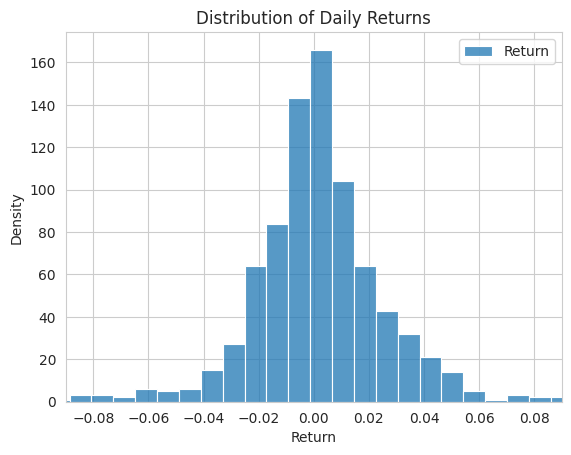

In [6]:
sns.histplot(returns[1:], bins=40,label='Return')
plt.xlabel('Return')  
plt.ylabel('Density')
plt.title('Distribution of Daily Returns')
plt.legend()
plt.gca().set_xlim(-0.09, 0.09)
plt.show()

In [7]:
# Date With Lowest and Highest Returns
print(returns.idxmin())
print(returns.idxmax())

2023-02-01 00:00:00
2021-04-06 00:00:00


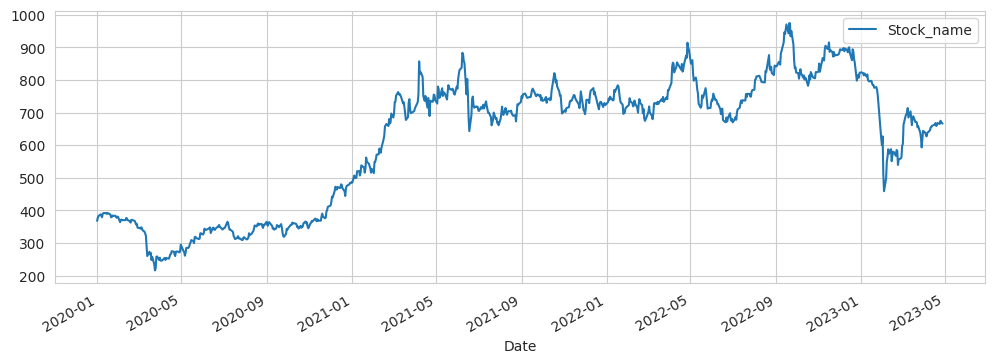

In [8]:
Open_price = df['Open']
Open_price.plot(label="Stock_name",figsize=(12,4))
plt.legend()

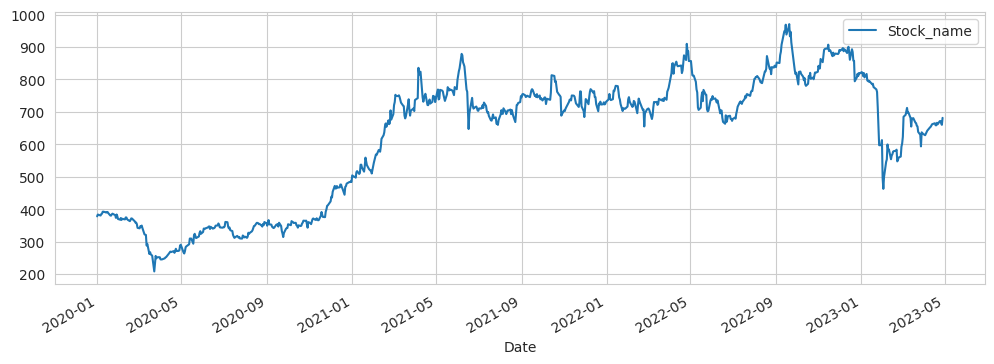

In [9]:
Closed_price = df['Close']
Closed_price.plot(label="Stock_name",figsize=(12,4))
plt.legend()


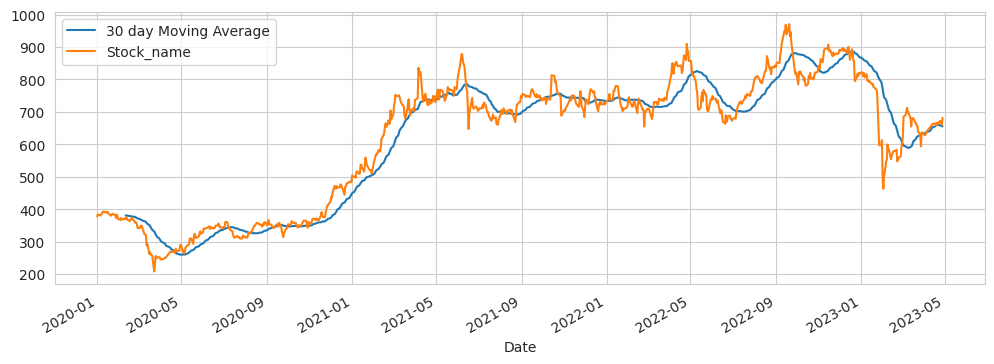

In [10]:
plt.figure(figsize=(12,4))
df['Close'].rolling(window=30).mean().plot(label='30 day Moving Average')
df['Close'].plot(label='Stock_name')
plt.legend()

In [11]:
df1=df.reset_index()['Close']


In [12]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]


In [14]:
training_size,test_size

(536, 290)

In [15]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [16]:
len(train_data)

536

In [17]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [18]:
print(X_train.shape), print(y_train.shape)

(435, 100)
(435,)


(None, None)

In [19]:
print(X_test.shape), print(ytest.shape)

(189, 100)
(189,)


(None, None)

In [20]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [21]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [22]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [23]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
7/7 [==============================] - 14s 1s/step - loss: 0.1367 - val_loss: 0.0608
Epoch 2/100
7/7 [==============================] - 4s 506ms/step - loss: 0.0235 - val_loss: 0.0426
Epoch 3/100
7/7 [==============================] - 3s 453ms/step - loss: 0.0159 - val_loss: 0.0126
Epoch 4/100
7/7 [==============================] - 3s 427ms/step - loss: 0.0079 - val_loss: 0.0098
Epoch 5/100
7/7 [==============================] - 4s 645ms/step - loss: 0.0048 - val_loss: 0.0164
Epoch 6/100
7/7 [==============================] - 4s 534ms/step - loss: 0.0037 - val_loss: 0.0093
Epoch 7/100
7/7 [==============================] - 2s 242ms/step - loss: 0.0030 - val_loss: 0.0095
Epoch 8/100
7/7 [==============================] - 2s 242ms/step - loss: 0.0026 - val_loss: 0.0089
Epoch 9/100
7/7 [==============================] - 2s 220ms/step - loss: 0.0022 - val_loss: 0.0088
Epoch 10/100
7/7 [==============================] - 2s 244ms/step - loss: 0.0022 - val_loss: 0.0088
Epoch 11/10

In [25]:
import tensorflow as tf

In [26]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

6/6 [==============================] - 0s 43ms/step


In [27]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [28]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

622.7305778538141

In [29]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

760.5164533691977

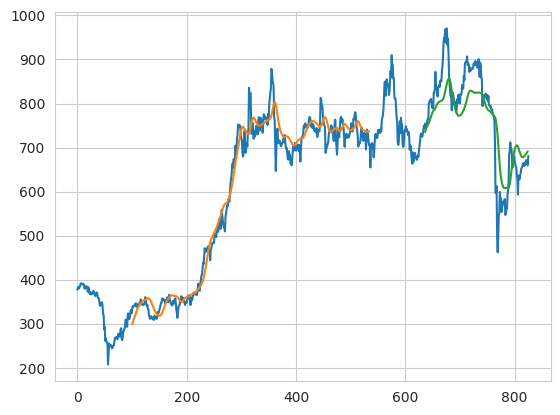

In [30]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [31]:
len(test_predict)

189

In [32]:
x_input=test_data[len(test_predict)-100:].reshape(1,-1)
x_input.shape

(1, 201)

In [33]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [51]:
from numpy import array

lst_output=[]
n_steps=len(x_input[0])
i=0
while(i<30):
    
    if(len(temp_input)>100):
        # print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.80693814 0.80831527 0.79887209 0.78733028 0.773231   0.78182179
 0.75670536 0.75060656 0.75860714 0.78975672 0.78333004 0.80300346
 0.77887078 0.78392026 0.77716568 0.80457735 0.80333135 0.80759392
 0.83152992 0.82051285 0.82110299 0.85920391 0.84621942 0.89579643
 0.8992721  0.90064922 0.90137057 0.91691262 0.89127153 0.89586199
 0.89330451 0.87061443 0.88484492 0.87323756 0.87723788 0.88110693
 0.87979536 0.87927079 0.88294314 0.89546854 0.8923864  0.89887865
 0.90320678 0.89048462 0.89855076 0.89573087 0.8833366  0.90104267
 0.90858415 0.88681227 0.85599057 0.89848511 0.88720572 0.85231822
 0.85133455 0.76896842 0.7846416  0.79919998 0.7902813  0.80234768
 0.8004459  0.80595447 0.80352812 0.78982228 0.80241324 0.78470716
 0.7985442  0.77198508 0.77205064 0.76746018 0.76968985 0.75972193
 0.75670536 0.75900059 0.74529476 0.74319629 0.73611383 0.7258181
 0.66279759 0.51039414 0.5104597  0.53098567 0.37687716 0.33398913
 0.38172996 0.44284873 0.45294776 0.51341071 0.4911

In [70]:
day_new=np.arange(1,len(x_input[0])+1)
day_pred=np.arange(len(x_input[0])+1,len(x_input[0])+31)

In [72]:
print(len(x_input[0]))
print(day_new.shape)
print(day_pred.shape)

200
(200,)
(30,)


In [47]:
len(df1)

826

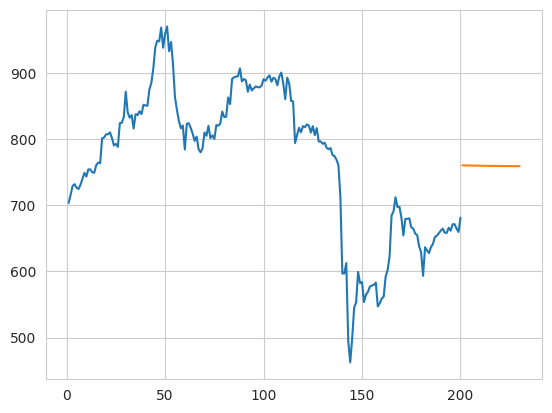

In [74]:

plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-len(x_input[0]):]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
